Time taken:  0.00031566619873046875


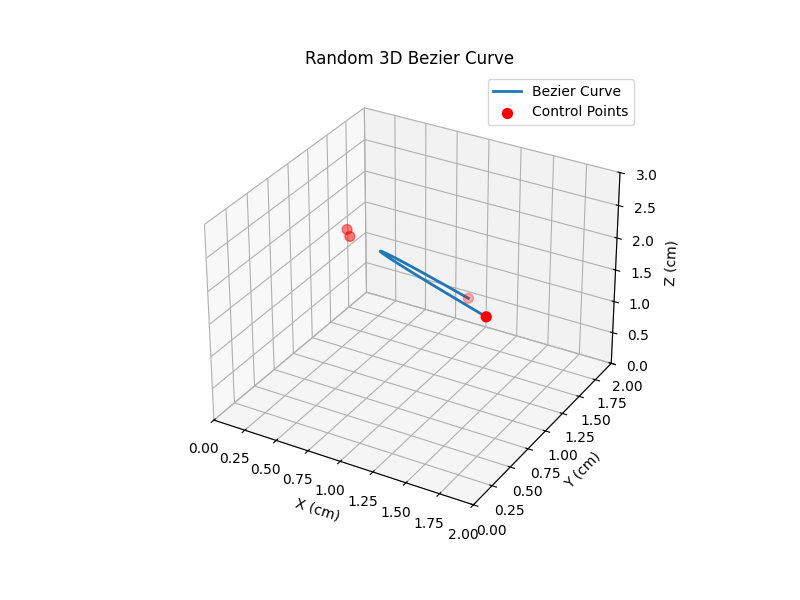

In [52]:
%matplotlib widget
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Not needed in newer versions of matplotlib

class BoundedBezierCurve3D:
    def __init__(self, control_points=None):
        """
        Initialize the Bezier curve. If no control points are provided,
        the curve can be sampled randomly using sample_random_curve().
        """
        self.bounds = {
            'x': (0, 2),  # 2cm bound in x
            'y': (0, 2),  # 2cm bound in y
            'z': (0, 3)   # 3cm bound in z
        }
        if control_points is None:
            self.control_points = np.empty((0, 3))
        else:
            self.control_points = self.enforce_bounds(np.array(control_points))
    
    def enforce_bounds(self, points):
        """Clip the points so that they lie within the defined bounds."""
        points[:, 0] = np.clip(points[:, 0], self.bounds['x'][0], self.bounds['x'][1])
        points[:, 1] = np.clip(points[:, 1], self.bounds['y'][0], self.bounds['y'][1])
        points[:, 2] = np.clip(points[:, 2], self.bounds['z'][0], self.bounds['z'][1])
        return points
        
    def generate_curve(self, num_points=100):
        """
        Generate points along the Bezier curve using a vectorized Bernstein basis.
        
        Args:
            num_points: Number of points along the curve
            
        Returns:
            An array of shape (num_points, 3) representing the curve.
        """
        n = len(self.control_points) - 1
        t = np.linspace(0, 1, num_points)
        
        # Create a grid for vectorized computation of Bernstein basis
        i = np.arange(n + 1)[:, None]  # shape (n+1, 1)
        t = t[None, :]                 # shape (1, num_points)
        binom_coeffs = comb(n, i)        # shape (n+1, 1)
        
        bernstein_matrix = binom_coeffs * (t ** i) * ((1 - t) ** (n - i))
        # Dot product with control points (shape (n+1, 3)) to get the curve (shape (num_points, 3))
        curve = bernstein_matrix.T.dot(self.control_points)
        
        return self.enforce_bounds(curve)
        
    def add_control_point(self, point):
        """Add a new control point (ensuring it is within bounds)."""
        point = np.array(point)
        point = self.enforce_bounds(point.reshape(1, 3)).flatten()
        self.control_points = np.vstack([self.control_points, point])
        
    def modify_control_point(self, index, new_point):
        """Modify an existing control point (ensuring it is within bounds)."""
        if 0 <= index < len(self.control_points):
            new_point = np.array(new_point)
            new_point = self.enforce_bounds(new_point.reshape(1, 3)).flatten()
            self.control_points[index] = new_point
            
    def get_curve_length(self, num_points=1000):
        """Calculate the approximate length of the curve."""
        points = self.generate_curve(num_points)
        segments = np.diff(points, axis=0)
        lengths = np.sqrt(np.sum(segments**2, axis=1))
        return np.sum(lengths)
        
    def sample_random_curve(self, num_control_points=4, num_points=100):
        """
        Generate a random Bezier curve by sampling random control points within bounds.
        
        Args:
            num_control_points: Number of control points to generate (degree = num_control_points - 1)
            num_points: Number of points along the resulting curve
            
        Returns:
            The generated curve as an array of shape (num_points, 3).
        """
        cp_x = np.random.uniform(self.bounds['x'][0], self.bounds['x'][1], size=num_control_points)
        cp_y = np.random.uniform(self.bounds['y'][0], self.bounds['y'][1], size=num_control_points)
        cp_z = np.random.uniform(self.bounds['z'][0], self.bounds['z'][1], size=num_control_points)
        cp = np.column_stack((cp_x, cp_y, cp_z))
        self.control_points = cp
        return self.generate_curve(num_points)


# -------------------------------
# Visualization (e.g., in a Jupyter Notebook)
# -------------------------------

# Create an instance without predefined control points
bezier = BoundedBezierCurve3D()

# Sample a random Bezier curve with 4 control points and 100 points along the curve

import time
now = time.time()
curve_points = bezier.sample_random_curve(num_control_points=4, num_points=100)
print("Time taken: ", time.time() - now)

# Create a 3D plot of the curve and control points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the Bezier curve
ax.plot(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2], label="Bezier Curve", lw=2)

# Plot the control points (in red)
ax.scatter(bezier.control_points[:, 0], bezier.control_points[:, 1],
           bezier.control_points[:, 2], color='red', s=50, label="Control Points")

# Set axis limits based on the bounds
ax.set_xlim(bezier.bounds['x'])
ax.set_ylim(bezier.bounds['y'])
ax.set_zlim(bezier.bounds['z'])

ax.set_title("Random 3D Bezier Curve")
ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("Z (cm)")
ax.legend()
plt.show()


Time to reset: 0.00012135505676269531


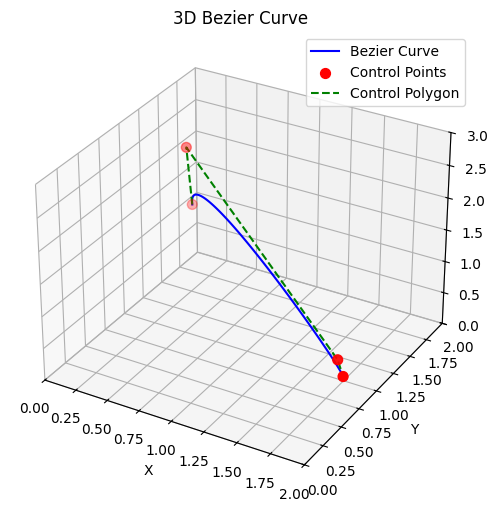

In [59]:
%matplotlib inline
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class BoundedBezierCurve3D:
    def __init__(self, num_control_points=4):
        """
        Initialize a bounded 3D Bezier curve with random control points.
        
        Args:
            num_control_points: Number of control points for the Bezier curve.
        """
        self.bounds = {
            'x': (0, 2),  # 2cm bound in x
            'y': (0, 2),  # 2cm bound in y
            'z': (0, 3)   # 3cm bound in z
        }
        self.num_control_points = num_control_points

    def reset(self):
        """Reset the curve with random control points within bounds."""
        self.control_points = np.random.uniform(
            low=[self.bounds['x'][0], self.bounds['y'][0], self.bounds['z'][0]],
            high=[self.bounds['x'][1], self.bounds['y'][1], self.bounds['z'][1]],
            size=(self.num_control_points, 3)
        )
        self._update_binomial()

    def _update_binomial(self):
        """Update binomial coefficients when control points change."""
        self.n = len(self.control_points) - 1
        if self.n >= 0:
            self.binomial = comb(self.n, np.arange(self.n + 1))
        else:
            self.binomial = np.array([])

    def generate_curve(self, num_points=100):
        """Generate points along the Bezier curve."""
        if len(self.control_points) == 0:
            return np.zeros((0, 3))
        
        t = np.linspace(0, 1, num_points)
        i = np.arange(self.n + 1)[:, np.newaxis]
        
        # Vectorized Bernstein polynomial calculation
        t_powers = t ** i
        one_minus_t_powers = (1 - t) ** (self.n - i)
        B = self.binomial[:, np.newaxis] * t_powers * one_minus_t_powers
        
        # Matrix multiplication for curve points
        curve = B.T @ self.control_points
        return curve

    def get_curve_length(self, num_points=1000):
        """Approximate curve length using vectorized operations."""
        points = self.generate_curve(num_points)
        return np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))

    def plot_curve(self, num_points=100):
        """Visualize the 3D Bezier curve using matplotlib."""
        curve = self.generate_curve(num_points)
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot the curve
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], label='Bezier Curve', color='b')
        
        # Plot control points
        ax.scatter(self.control_points[:, 0], self.control_points[:, 1], self.control_points[:, 2],
                   color='r', label='Control Points', s=50)
        
        # Draw lines connecting control points
        ax.plot(self.control_points[:, 0], self.control_points[:, 1], self.control_points[:, 2],
                color='g', linestyle='--', label='Control Polygon')
        
        # Set axis labels and limits
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(self.bounds['x'])
        ax.set_ylim(self.bounds['y'])
        ax.set_zlim(self.bounds['z'])
        
        ax.legend()
        plt.title('3D Bezier Curve')
        plt.show()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    # Create a random Bezier curve
    bezier = BoundedBezierCurve3D(num_control_points=4)
    
    # Reset and generate a new random curve
    import time
    now = time.time()
    bezier.reset()
    print("Time to reset:", time.time() - now)
    bezier.plot_curve()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the beta schedule function
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    if schedule_name == "linear":
        scale = 1000 / num_diffusion_timesteps
        betas = np.linspace(scale * 0.0001, scale * 0.02, num_diffusion_timesteps, dtype=np.float64)
        return np.array(betas, dtype=np.float64)
    elif schedule_name == "squaredcos_cap_v2":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

# Define the alpha_bar function for squaredcos_cap_v2
def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas, dtype=np.float64)

# Define the diffusion parameters
num_diffusion_timesteps = 1000
beta_schedule = "linear"  # or "squaredcos_cap_v2"

# Compute betas and other related terms
betas = get_named_beta_schedule(beta_schedule, num_diffusion_timesteps)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)

# Compute posterior variance
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

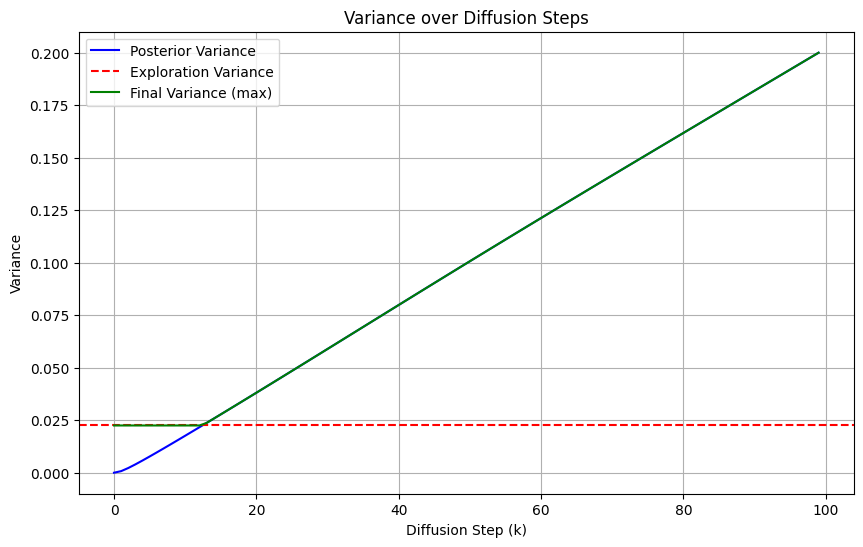

In [8]:
# Define exploration noise variance (var_explore)
var_explore = 0.0225# Example value, adjust as needed

# Compute the final variance
final_variance = np.maximum(posterior_variance, var_explore)

# Plot posterior_variance, var_explore, and final_variance
plt.figure(figsize=(10, 6))
plt.plot(posterior_variance, label="Posterior Variance", color="blue")
plt.axhline(y=var_explore, color="red", linestyle="--", label="Exploration Variance")
plt.plot(final_variance, label="Final Variance (max)", color="green")
plt.xlabel("Diffusion Step (k)")
plt.ylabel("Variance")
plt.title("Variance over Diffusion Steps")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
0.15**2


0.0225